<div align="left">
<img align="left" src="datasciencebowl.png" >
<div> <b> Kaggle </b></div>
<div> 2018 Data Science Bowl </div>
<div> Pedro D. Marrero Fernandez</div>
<div> https://www.kaggle.com/c/data-science-bowl-2018/discussion/47770 </div>
<div> :), :(, :/</div>
</div>

In [1]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import csv
import scipy.misc
import math 

from deep.datasets import imageutl as utl
from deep import visualization as view

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [2]:
pathdataset = '../db'
namedataset = 'databoewl'
metadata = 'stage1_train_labels.csv'
pathname = os.path.join(pathdataset, namedataset);
pathmetadata = os.path.join(pathdataset, namedataset, metadata)

base_folder = pathname
sub_folder =  utl.trainfile
id_file_name = metadata
folders_image='images'
folders_masks='masks'

dataloader = utl.dsxbProvide.create(
    base_folder, 
    sub_folder, 
    id_file_name, 
    folders_image, 
    folders_masks
    )

print(len(dataloader))
print(':)!!!')

670
:)!!!


# DATA AUMENTATION
## TRANFORMATIONS

In [3]:
import cv2
from scipy.interpolate import griddata
# Import stuff
import numpy as np
import pandas as pd
import cv2
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt
from skimage import color
import skimage.util as skutl


In [5]:
# Define function to draw a grid
def draw_grid(im, grid_size, color=(1,), thickness=1):
    
    imgrid = im.copy()
    #imgrid = view.torgb(im)
    m,n = imgrid.shape[:2]
    
    imgrid = imgrid - np.min(imgrid)
    imgrid = imgrid / np.max(imgrid)
    
    # Draw grid lines
    for i in range(0, n-1, grid_size):
        cv2.line(imgrid, (i+grid_size, 0), (i+grid_size, m), color=color, thickness=thickness)
    for j in range(0, m-1, grid_size):
        cv2.line(imgrid, (0, j+grid_size), (n, j+grid_size), color=color, thickness=thickness)

    return imgrid

### Kaggle competition 

In [9]:

# Kaggle
# https://www.kaggle.com/bguberfain/elastic-transform-for-data-augmentation
# Function to distort image

def elastic_transform(image, alpha, sigma, alpha_affine, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_ (with modifications).
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
         Convolutional Neural Networks applied to Visual Document Analysis", in
         Proc. of the International Conference on Document Analysis and
         Recognition, 2003.

     Based on https://gist.github.com/erniejunior/601cdf56d2b424757de5
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    shape_size = shape[:2]
    
    # Random affine
    center_square = np.float32(shape_size) // 2
    square_size = min(shape_size) // 3
    pts1 = np.float32([center_square + square_size, [center_square[0]+square_size, center_square[1]-square_size], center_square - square_size])
    pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dz = np.zeros_like(dx)

    x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))

    return map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)



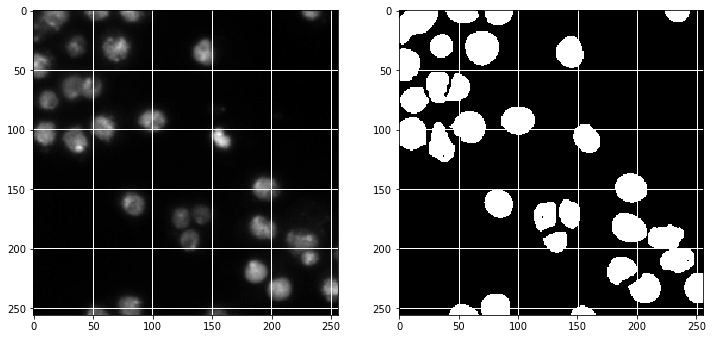

(256, 256)
(256, 256, 2)


In [22]:
# Example

image, label = dataloader[ 1 ]
image =  color.rgb2gray(image)
mask  = (label>0).astype(np.float)
mask  = np.max(mask,axis=2)


# Draw grid lines
image = draw_grid(image, 50)
mask  = draw_grid(mask, 50)

# Merge images into separete channels (shape will be (cols, rols, 2))
im_merge = np.concatenate((image[...,None], mask[...,None]), axis=2)

plt.figure( figsize=(12,12) )
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.subplot(122)
plt.imshow(mask, cmap='gray')

plt.show()

print(mask.shape)
print(im_merge.shape)

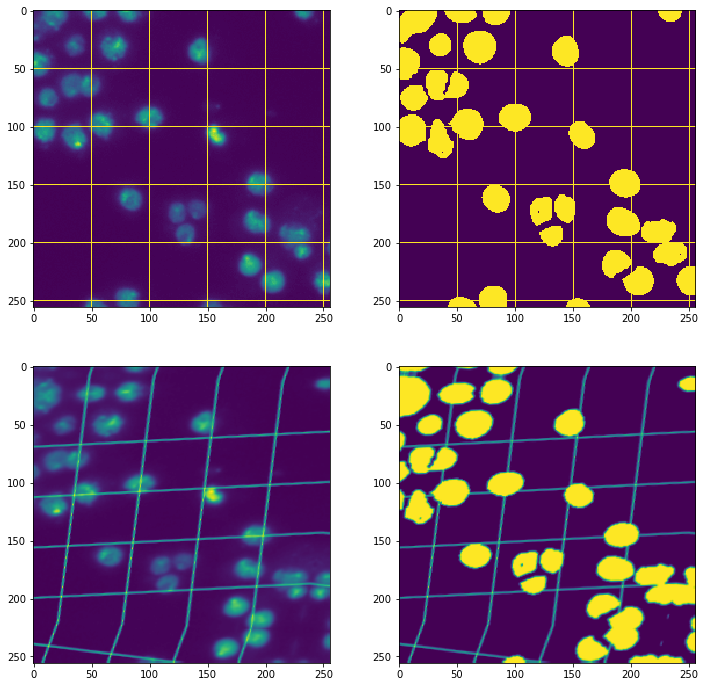

In [24]:

im_merge = elastic_transform(im_merge, im_merge.shape[1] * 3, im_merge.shape[1] * 0.7, im_merge.shape[1] * 0.09) 

image_t = im_merge[:,:,0]
mask_t = im_merge[:,:,1]

plt.figure( figsize=(12,12) )
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(mask)
plt.subplot(223)
plt.imshow(image_t)
plt.subplot(224)
plt.imshow(mask_t)

plt.show()

### Elastic implementation ***

In [6]:
def geo_elastic_transform(shape, size_grid, deform):
        
    #shape = image.shape
    m,n=shape[:2]
    grid_x, grid_y = np.mgrid[:m,:n]
    
    source = [] 
    destination = []

    for i in range(int(m/size_grid)+1):
        for j in range(int(n/size_grid)+1):
            
            source = source + [np.array([i*size_grid, j*size_grid])]
            noise=(np.random.uniform(-deform,deform,2)).astype(np.int)
            
            if i==0 or j==0 or i==int(m/size_grid) or j==int(n/size_grid): noise = np.array([0,0])
            destination = destination + [np.array([i*size_grid, j*size_grid])+noise ]

    source=np.vstack(source)
    destination=np.vstack(destination)
    destination[destination<0] = 0
    destination[destination>=n] = n-1
    
    grid_z = griddata(destination, source, (grid_x, grid_y), method='cubic')

    map_x = np.append([], [ar[:,1] for ar in grid_z]).reshape(m,n)
    map_y = np.append([], [ar[:,0] for ar in grid_z]).reshape(m,n)
    map_x_32 = map_x.astype('float32')
    map_y_32 = map_y.astype('float32')

    #image = cv2.remap(image, map_x_32, map_y_32, cv2.INTER_CUBIC)
    return map_x_32, map_y_32


Image:  -0.0931089003468 1.0545500273 (256, 320)
Mask:  -0.264647588367 1.29150390625 (256, 320)


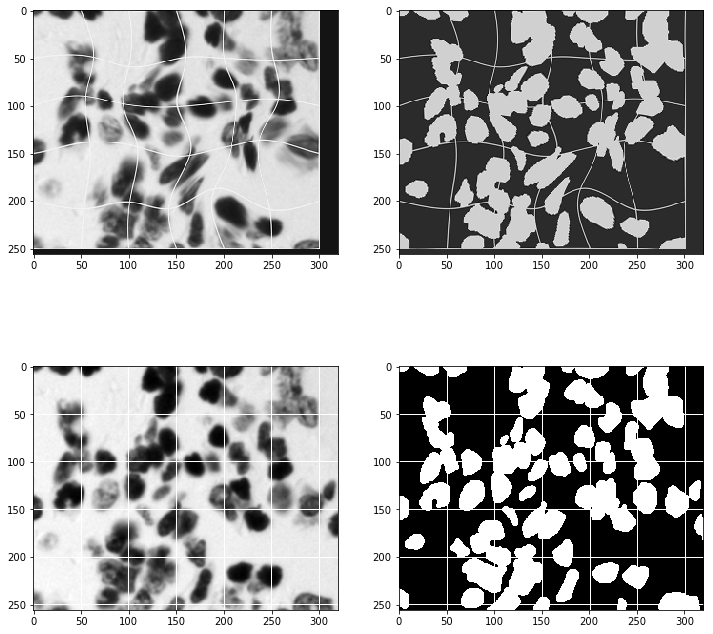

In [11]:

image, label = dataloader[ 2 ]
image =  color.rgb2gray(image)
mask = (label>0).astype(np.float)
mask = np.max(mask,axis=2)

# Draw grid lines
image = draw_grid(image, 50, color=(1,))
mask  = draw_grid(mask, 50, color=(1,) )

mapx, mapy = geo_elastic_transform(image.shape, 50, 15 )
image_t = cv2.remap(image, mapx, mapy, cv2.INTER_CUBIC)
mask_t = cv2.remap(mask, mapx, mapy, cv2.INTER_CUBIC)


print('Image: ', np.min(image_t), np.max(image_t), image_t.shape )
print('Mask: ', np.min(mask_t), np.max(mask_t), mask_t.shape )


plt.figure( figsize=(12,12) )
plt.subplot(221)
plt.imshow(image_t, cmap='gray')
plt.subplot(222)
plt.imshow(mask_t, cmap='gray')
plt.subplot(223)
plt.imshow(image, cmap='gray')
plt.subplot(224)
plt.imshow(mask, cmap='gray')

plt.show()


### Geometric Transformations

In [43]:

def geometric_transform(image, mask, angle, translation, warp):
    """
    Transform the image for data augmentation
    Arguments:
        * image: Input image
        * mask:  Input mask
        * angle: Max rotation angle, in degrees. Direction of rotation is random.
        * translation: Max translation amount in both x and y directions,
            expressed as fraction of total image width/height
        * warp: Max warp amount for each of the 3 reference points,
            expressed as fraction of total image width/height

    Returns:
        * Transformed input as an np.array() object
    """

    height, width = image.shape[:2]
    
    # Rotation
    center = (width//2, height//2)
    angle_rand = np.random.uniform(-angle, angle)
    rotation_mat = cv2.getRotationMatrix2D(center, angle_rand, 1)
    
    image = cv2.warpAffine(image, rotation_mat, (width, height) )
    mask  = cv2.warpAffine(mask, rotation_mat, (width, height) )
    
    
    # Translation
    x_offset = translation * width * np.random.uniform(-1, 1)
    y_offset = translation * height * np.random.uniform(-1, 1)
    translation_mat = np.array([[1, 0, x_offset], [0, 1, y_offset]])

    image = cv2.warpAffine(image, translation_mat, (width, height))
    mask = cv2.warpAffine(mask, translation_mat, (width, height))
  

    # Warp
    # NOTE: The commented code below is left for reference
    # The warp function tends to blur the image, so it is not useds
    
    src_triangle = np.float32([[0, 0], [0, height], [width, 0]])
    x_offsets = [warp * width * np.random.uniform(-1, 1) for _ in range(3)]
    y_offsets = [warp * height * np.random.uniform(-1, 1) for _ in range(3)]
    dst_triangle = np.float32([[x_offsets[0], y_offsets[0]],\
                             [x_offsets[1], height + y_offsets[1]],\
                             [width + x_offsets[2], y_offsets[2]]])
    warp_mat = cv2.getAffineTransform(src_triangle, dst_triangle)
    
    image = cv2.warpAffine(image, warp_mat, (width, height))
    mask = cv2.warpAffine(mask, warp_mat, (width, height))
    ''''''
        
    # Horizontal mirror
    if bool(np.random.randint(0,2)):
        image = np.fliplr(image)
        mask = np.fliplr(mask)
        
    # Vertical mirror
    if bool(np.random.randint(0,2)):
        image = np.flipud(image)
        mask = np.flipud(mask)

    return image, mask


Image:  0.0 0.265124287325 (360, 360)
Mask:  0.0 1.0 (360, 360)


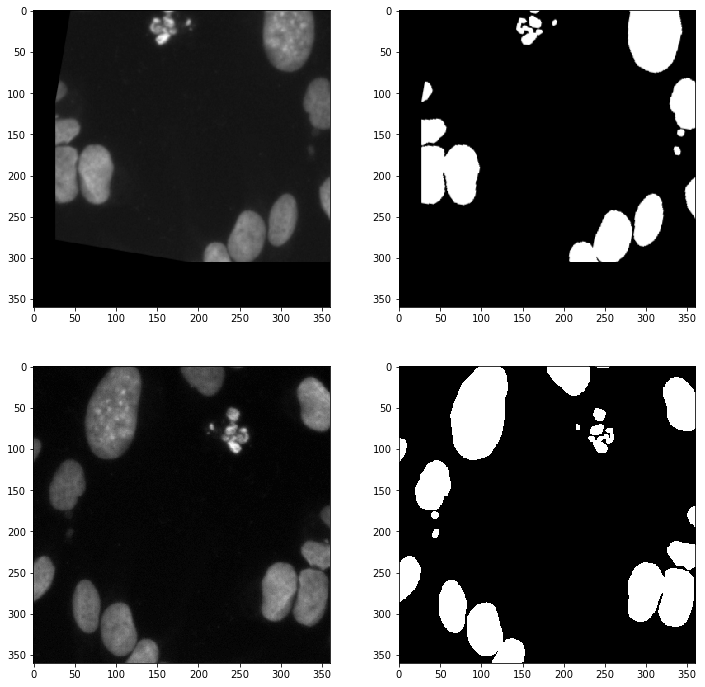

In [69]:
# Example 

image, label = dataloader[ 3 ]
image =  color.rgb2gray(image)
mask = (label>0).astype(np.float)
mask = np.max(mask,axis=2)

angle = 15
translation = 0.2
warp = 0.0  #0.05

image_t, mask_t = geometric_transform(image, mask, angle, translation, warp)

print('Image: ', np.min(image_t), np.max(image_t), image_t.shape  )
print('Mask: ', np.min(mask_t), np.max(mask_t), mask_t.shape  )

plt.figure( figsize=(12,12) )
plt.subplot(221)
plt.imshow(image_t, cmap='gray')
plt.subplot(222)
plt.imshow(mask_t, cmap='gray')
plt.subplot(223)
plt.imshow(image, cmap='gray')
plt.subplot(224)
plt.imshow(mask, cmap='gray')

plt.show()


### Color Transformations

In [26]:

def compute_norm_mat(base_width, base_height): 
    # normalization matrix used in image pre-processing 
    x      = np.arange(base_width)
    y      = np.arange(base_height)
    X, Y   = np.meshgrid(x, y)
    X      = X.flatten()
    Y      = Y.flatten() 
    A      = np.array([X*0+1, X, Y]).T 
    A_pinv = np.linalg.pinv(A)
    return A, A_pinv

def preproc_img(img, A, A_pinv):
    # compute image histogram 
    img_flat = img.flatten()
    img_hist = np.bincount(img_flat, minlength = 256)

    # cumulative distribution function 
    cdf = img_hist.cumsum() 
    cdf = cdf * (2.0 / cdf[-1]) - 1.0 # normalize 

    # histogram equalization 
    img_eq = cdf[img_flat] 

    diff = img_eq - np.dot(A, np.dot(A_pinv, img_eq))

    # after plane fitting, the mean of diff is already 0 
    std = np.sqrt(np.dot(diff,diff)/diff.size)
    if std > 1e-6: 
        diff = diff/std
    return diff.reshape(img.shape)

def color_transform(image):

    # Gaussian noise
    #if bool(np.random.randint(0,2)):
    #    image = skutl.random_noise(image, mode='gaussian', seed=None, clip=True)
        
    row,col = image.shape
    mean = 0
    var = 0.1
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col))
    gauss = gauss.reshape(row,col)
    image = image + 0.05*gauss

    # Gaussian blur
    if bool(np.random.randint(0,2)):
        wnd = np.random.randint(1, 3) * 2 + 1
        image = cv2.GaussianBlur(image, (wnd, wnd), 0);
        
    # Normalization
    image = image - np.min(image)
    image = image / np.max(image)
    

    return image


Image:  0.00392156862745 0.709803921569 (256, 256)
Image:  -2.53140390543 3.51434853269 (256, 256)


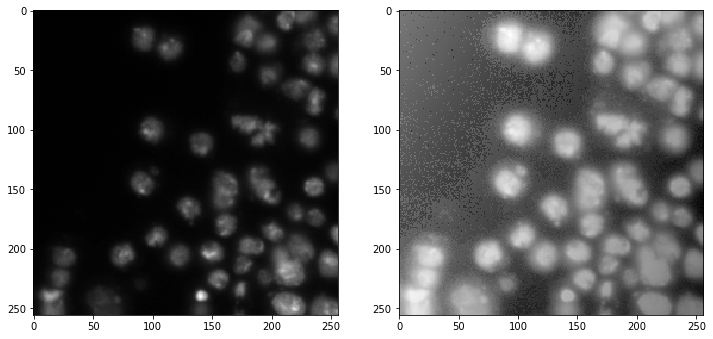

In [42]:
# Example

image, label = dataloader[ 6 ]
image =  color.rgb2gray(image)
mask = (label>0).astype(np.float)
mask = np.max(mask,axis=2)

h,w = image.shape[:2]
A,Ainv = compute_norm_mat(w,h)

image_t = image
#image_t = color_transform(image)

print('Image: ', np.min(image_t), np.max(image_t), image_t.shape  )

image_t = (image_t*255).astype(np.uint32)
image_t = preproc_img(image_t,A,Ainv)

print('Image: ', np.min(image_t), np.max(image_t), image_t.shape  )



plt.figure( figsize=(12,12) )
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.subplot(122)
plt.imshow(image_t, cmap='gray')
plt.show()



In [ ]:
### Size transformer

In [153]:
def size_transform(imagein, size=512, mode=None):

    height, width = imagein.shape;
    image = np.array(imagein.copy())

    asp = float(height)/width;
    w = size; 
    h = int(w*asp);

    image_x = scipy.misc.imresize(image, (h,w), interp='bilinear', mode=mode);
    image = np.zeros((w,w));
    ini = int(round((w-h)/2.0));
    image[ini:h+ini,:] = image_x;

    return image


Image:  1.0 252.0 (512, 512)


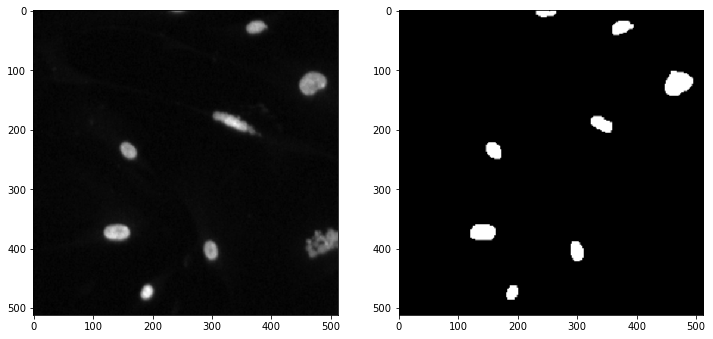

In [155]:
image, label = dataloader[ 5 ]
image =  color.rgb2gray(image)
mask = (label>0).astype(np.float)
mask = np.max(mask,axis=2)

image_t = size_transform(image, size=512, mode=None)
mask_t = size_transform(mask, size=512, mode='F')

print('Image: ', np.min(image_t), np.max(image_t), image_t.shape  )

plt.figure( figsize=(12,12) )
plt.subplot(121)
plt.imshow(image_t, cmap='gray')
plt.subplot(122)
plt.imshow(mask_t, cmap='gray')
plt.show()




In [8]:


def size_unet_transform(imagein, size=512, mode=None):
    
    height, width = imagein.shape;
    image = np.array(imagein.copy())
    
    asp = float(height)/width
    w = size
    h = int(w*asp)

    #resize mantaining aspect ratio
    image_x = scipy.misc.imresize(image, (h,w), interp='bilinear', mode=mode)
    image = np.zeros((w,w))

    #crop image
    ini = int(round((w-h) / 2.0))
    image[ini:ini+h,:] = image_x

    #unet required input size
    downsampleFactor = 16;
    d4a_size   = 0;
    padInput   = (((d4a_size *2 +2 +2)*2 +2 +2)*2 +2 +2)*2 +2 +2;
    padOutput  = ((((d4a_size -2 -2)*2-2 -2)*2-2 -2)*2-2 -2)*2-2 -2;
    d4a_size   = math.ceil( (size - padOutput)/downsampleFactor);
    input_size = downsampleFactor*d4a_size + padInput;

    offset=(input_size-size)//2
    image_x = np.zeros((input_size,input_size));

    #crop for required size
    image_x[offset:-offset,offset:-offset,] = image
    
    return image_x
    


Image:  0.00392156862745 1.0 (256, 256)
Image:  0.0 0.985539197922 (700, 700)


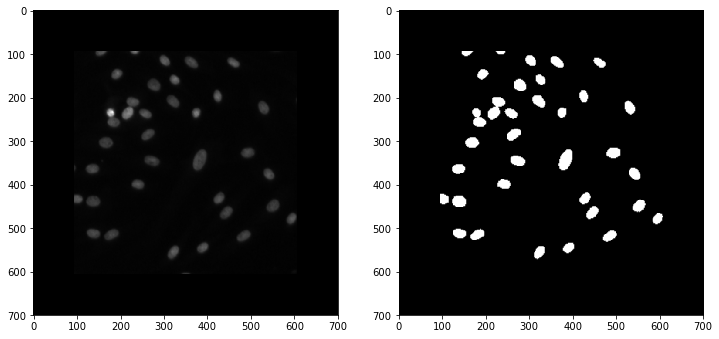

In [25]:
image, label = dataloader[ 1 ]
image =  color.rgb2gray(image)
mask = (label>0).astype(np.float)
mask = np.max(mask,axis=2)

image_t = size_unet_transform(image, size=512, mode='F')
mask_t = size_unet_transform(mask, size=512, mode='F')

print('Image: ', np.min(image), np.max(image), image.shape  )
print('Image: ', np.min(image_t), np.max(image_t), image_t.shape  )

plt.figure( figsize=(12,12) )
plt.subplot(121)
plt.imshow(image_t, cmap='gray')
plt.subplot(122)
plt.imshow(mask_t, cmap='gray')
plt.show()
